In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import cv2 as cv
import open3d
import numpy as np

from utils.io_utils import get_matching_pairs, get_images, get_depths
from utils.calib_utils import detect_keypoints, undistort_intrinsics, to_homogeneous, to_cartesian, undistort_images, transform2local, plane2plane_transformation, undistort_depths, to_norm_image_coord, compose_fund_mat, optimize_pose_lm, pointcloudify_depths, optimize_translation_lm
from utils.vis_utils import plot_figures, plot_projected_keypoints, plot_projected_pcd, to_open3d, plot_epipolar_lines, draw_chessboard_corners, normalize_image

np.set_printoptions(suppress=True)


WARNING - 2021-03-29 14:31:10,715 - core - In /home/konstantin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
WARNING - 2021-03-29 14:31:10,716 - core - In /home/konstantin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
WARNING - 2021-03-29 14:31:10,717 - core - In /home/konstantin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
WARNING - 2021-03-29 14:31:10,719 - core - In /home/konstantin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
T

### Load data

In [4]:
img_ext = '.png'
depth_ext = '.npy'
period = 13

In [5]:
# Data paths
s10_images_path = "/home/konstantin/datasets/bandeja-sequence/2021-02-23-21-18-22/smartphone_video_frames"
azure_images_path = "/home/konstantin/datasets/bandeja-sequence/2021-02-23-21-18-22/_azure_ir_image_raw"
azure_depths_path = "/home/konstantin/datasets/bandeja-sequence/2021-02-23-21-18-22/_azure_depth_image_raw"

In [6]:
# Deterime matching pairs between s10 and azure either by matching or providing the list of timestamps manually
s10_timestamps, azure_timestamps = get_matching_pairs(s10_images_path, azure_images_path)

In [7]:
s10_images = get_images(s10_images_path, period=period, file_name_list=[fn + img_ext for fn in s10_timestamps])

In [8]:
azure_images = get_images(azure_images_path, period=period, file_name_list=[fn + img_ext for fn in azure_timestamps])
azure_depths = get_depths(azure_depths_path, period=period, file_name_list=[fn + depth_ext for fn in azure_timestamps])

In [9]:
s10_timestamps = s10_timestamps[::period]
azure_timestamps = azure_timestamps[::period]

In [10]:
# Load intrinsics cailbration results which should include intrinsics, distortion coefficients and undistorted intrinsics
s10_intrinsics_calib = np.load('calib_output/s10_intrinsics.npy', allow_pickle=True).item()

s10_intrinsics = s10_intrinsics_calib['intrinsics']
s10_dist_coeff = s10_intrinsics_calib['dist_coeff']
s10_undist_intrinsics = s10_intrinsics_calib['undist_intrinsics']

In [11]:
# Stock calibration for azure
azure_intrinsics = np.array([[503.9581604003906, 0.0, 325.4591064453125],
                             [0.0, 504.0079345703125, 340.33404541015625],
                             [0.0, 0.0, 1.0]])

azure_dist_coeff = np.array([5.268435478210449, 3.5621509552001953, -6.14773682627856e-07, -4.438921678229235e-05, 0.1832902431488037, 5.597447872161865, 5.32110071182251, 0.9697896838188171])

azure_undist_intrinsics = undistort_intrinsics(azure_images, azure_intrinsics, azure_dist_coeff)

In [12]:
# Undistort all data before the work
s10_images = undistort_images(s10_images, s10_intrinsics, s10_dist_coeff, s10_undist_intrinsics)
azure_images = undistort_images(azure_images, azure_intrinsics, azure_dist_coeff, azure_undist_intrinsics)

In [13]:
azure_depths = undistort_depths(azure_depths, azure_intrinsics, azure_dist_coeff, azure_undist_intrinsics)

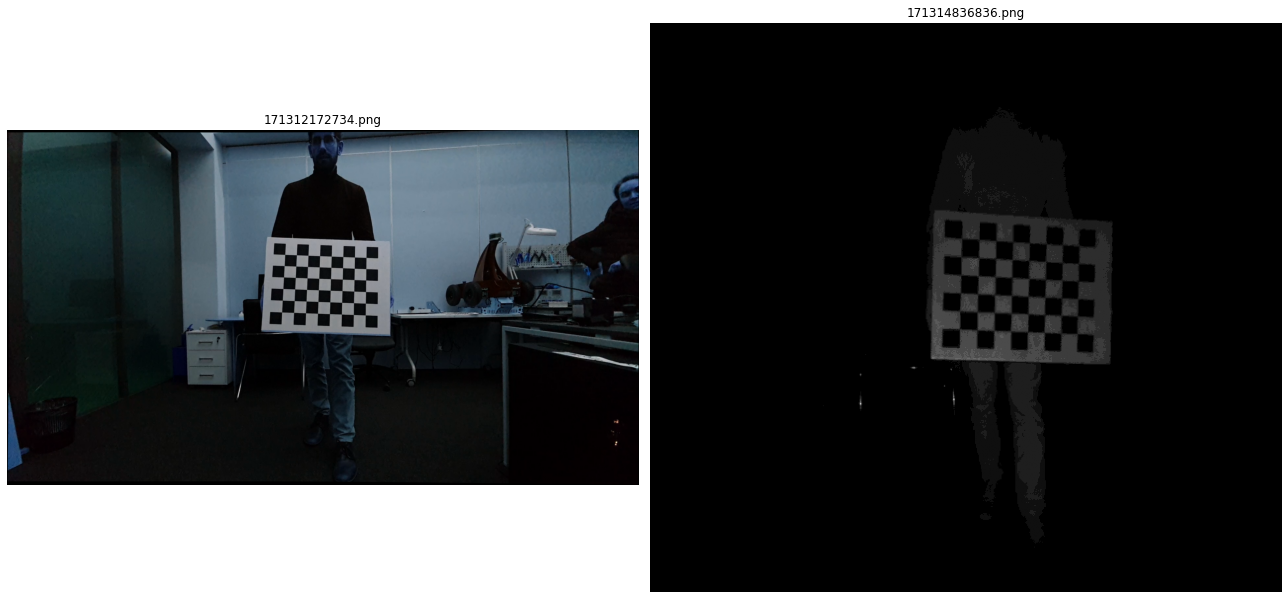

In [14]:
idx = 2

check_s10_key, check_azure_key = s10_timestamps[idx], azure_timestamps[idx]

plot_figures({check_s10_key + img_ext: s10_images[check_s10_key + img_ext], 
              check_azure_key + img_ext: normalize_image(azure_images[check_azure_key + img_ext])}, 1, 2)

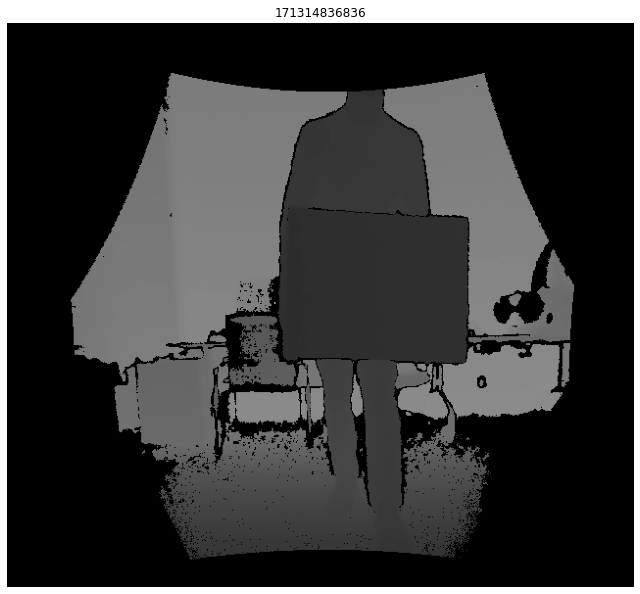

In [15]:
check_azure_depth = azure_depths[check_azure_key + depth_ext]

plot_figures({check_azure_key: check_azure_depth}, size=(9, 9))

### Detect keypoints

In [16]:
pattern_size = (8, 6)
edge_length = 0.05

In [17]:
# Detect keypoint
s10_detections = detect_keypoints(s10_images, pattern_size, edge_length)
azure_detections = detect_keypoints(azure_images, pattern_size, edge_length)

In [18]:
# Leave only those pairs that have detections on both images
s10_det_mask = np.array([t + img_ext in s10_detections for t in s10_timestamps])
azure_det_mask = np.array([t + img_ext in azure_detections for t in azure_timestamps])

det_mask = s10_det_mask & azure_det_mask

d_s10_timestamps, d_azure_timestamps = s10_timestamps[det_mask], azure_timestamps[det_mask]

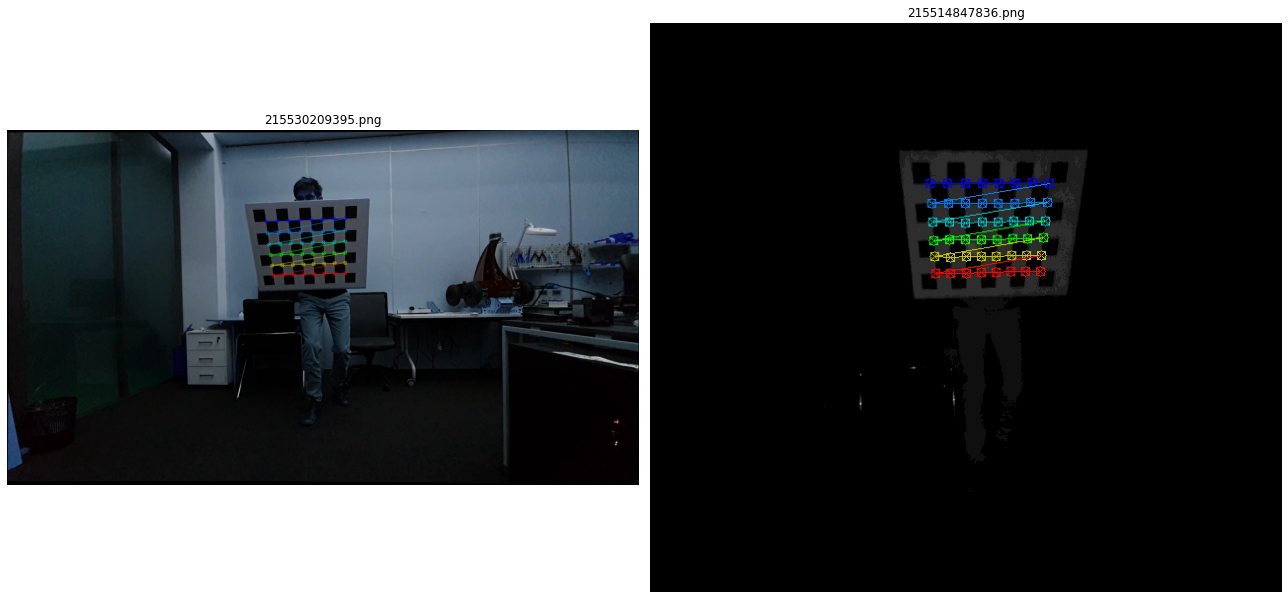

In [142]:
# Detections on azure may be innacurate. When selecting final pair make sure their detections are accurate

idx = 18

check_s10_key, check_azure_key = d_s10_timestamps[idx] + img_ext, d_azure_timestamps[idx] + img_ext


plot_figures({check_s10_key: draw_chessboard_corners(s10_images[check_s10_key], 
                                                     s10_detections[check_s10_key][1], 
                                                     pattern_size),
              check_azure_key: draw_chessboard_corners(azure_images[check_azure_key], 
                                                       azure_detections[check_azure_key][1], 
                                                       pattern_size, normalize=True)}, 1, 2)

### s10-to-chessboard transformation

In [20]:
# Solve PnP for find transformation between s10 keypoints and points on the board

s10_chess = {}

for ts in d_s10_timestamps:
    scene_points, kp = s10_detections[ts + img_ext]
    success, r, t = cv.solvePnP(scene_points, kp, s10_undist_intrinsics, None, flags=cv.SOLVEPNP_IPPE)
    
    if success:
        dS = np.zeros((4, 4))
        dS[:3, :3] = cv.Rodrigues(r)[0]
        dS[:3, 3] = np.reshape(t, -1)
        dS[3, 3] = 1
        
        s10_local_scene_points = to_cartesian((dS @ to_homogeneous(scene_points).transpose()).transpose())
        
        s10_chess[ts] = s10_local_scene_points


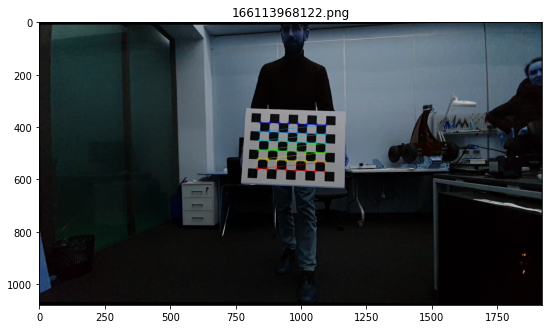

In [21]:
# Visualize transformed scene points with the estimated by PnP transformation to make sure the solution make sense
idx = 0

check_key = d_s10_timestamps[idx] + img_ext

plot_projected_keypoints(s10_images[check_key], s10_chess[check_key.split('.')[0]], s10_undist_intrinsics, check_key, pattern_size)

### azure-to-chessboard transformation

In [22]:
# Take keypoints from azure and use depth to create a point cloud out of them

azure_chess = {}

for t in d_azure_timestamps:
    kp = np.squeeze(azure_detections[t + img_ext][1], 1)
    depth = azure_depths[t + depth_ext]
    
    norm_kp = to_norm_image_coord(kp, azure_undist_intrinsics)
    
    azure_local_kp = transform2local(kp, norm_kp, depth)
    
    azure_chess[t] = azure_local_kp

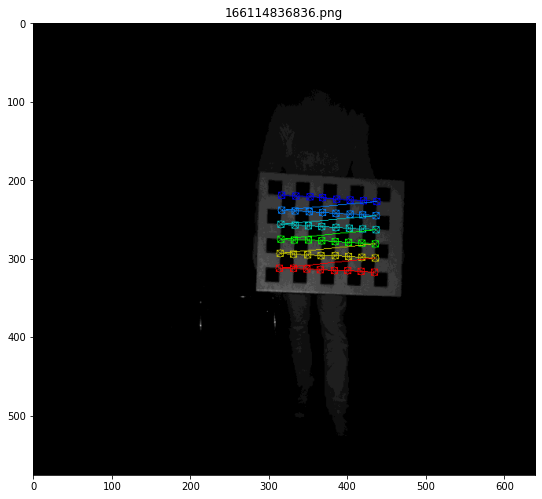

In [23]:
# Agian perform the check to make sure that obtained points are reasonable
idx = 0

check_key = d_azure_timestamps[idx] + img_ext

plot_projected_keypoints(azure_images[check_key], azure_chess[check_key.split('.')[0]], azure_undist_intrinsics, check_key, pattern_size, normalize=True)

In [24]:
# Visualize two chessboards next to each other and get the avg. error between corresponding points

idx = 0

check_azure_chess, check_s10_chess = azure_chess[d_azure_timestamps[idx]], s10_chess[d_s10_timestamps[idx]]

open3d.visualization.draw_geometries([to_open3d(check_azure_chess), to_open3d(check_s10_chess)])

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [25]:
np.linalg.norm(check_s10_chess - check_azure_chess, axis=-1).mean()

0.22291489746078016

### azure-s10-extrinsics guess

In [26]:
# Estimate the point-to-point transformation between two pointclouds

extrinsics = {}

for s10_t, azure_t in zip(d_s10_timestamps, d_azure_timestamps):
    s10_chessi = s10_chess[s10_t]
    azure_chessi = azure_chess[azure_t]
    
    extrinsics[s10_t + ' ' + azure_t] = plane2plane_transformation(azure_chessi, s10_chessi)


In [32]:
# Pick only one solution that corresponds to a pair with the best inital estimate. 
# Make sure the transformation is geometrically feasible

t_norm_p2p = []
T_p2p = []

for i, (s10_t, azure_t) in enumerate(zip(d_s10_timestamps, d_azure_timestamps)):
    azure_chessi, s10_chessi = azure_chess[azure_t], s10_chess[s10_t]
    Ti = extrinsics[s10_t + ' ' + azure_t]
    
    t_azure_chessi = to_cartesian((Ti @ to_homogeneous(azure_chessi).transpose()).transpose())
    
    t_normi = np.linalg.norm(t_azure_chessi - s10_chessi, axis=-1).mean()
    
    t_norm_p2p.append(t_normi)
    T_p2p.append(Ti)

t_norm_p2p = np.array(t_norm_p2p)
T_p2p = np.array(T_p2p)

In [33]:
t_norm_idx = np.argsort(t_norm_p2p)

T_init = T_p2p[t_norm_idx[1]]

print(T_init)

[[ 0.99828083  0.07024348 -0.01857575 -0.0696636 ]
 [ 0.00238021  0.99304448 -0.00206997  0.1949622 ]
 [-0.05306589 -0.00333469  0.9981204  -0.01580814]
 [ 0.          0.          0.          1.        ]]


In [42]:
# Check the selected transformation
idx = 3

check_azure_key, check_s10_key = d_azure_timestamps[idx], d_s10_timestamps[idx]

check_azure_chess, check_s10_chess = azure_chess[check_azure_key], s10_chess[check_s10_key]

check_T = T_init

In [43]:
# 1) avg. error between points
check_t_azure_chess = to_cartesian((check_T @ to_homogeneous(check_azure_chess).transpose()).transpose())

np.linalg.norm(check_t_azure_chess - check_s10_chess, axis=-1).mean()

0.05125980486421275

In [44]:
# 2) by examining the solution visually
open3d.visualization.draw_geometries([to_open3d(check_t_azure_chess), to_open3d(check_s10_chess)])

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


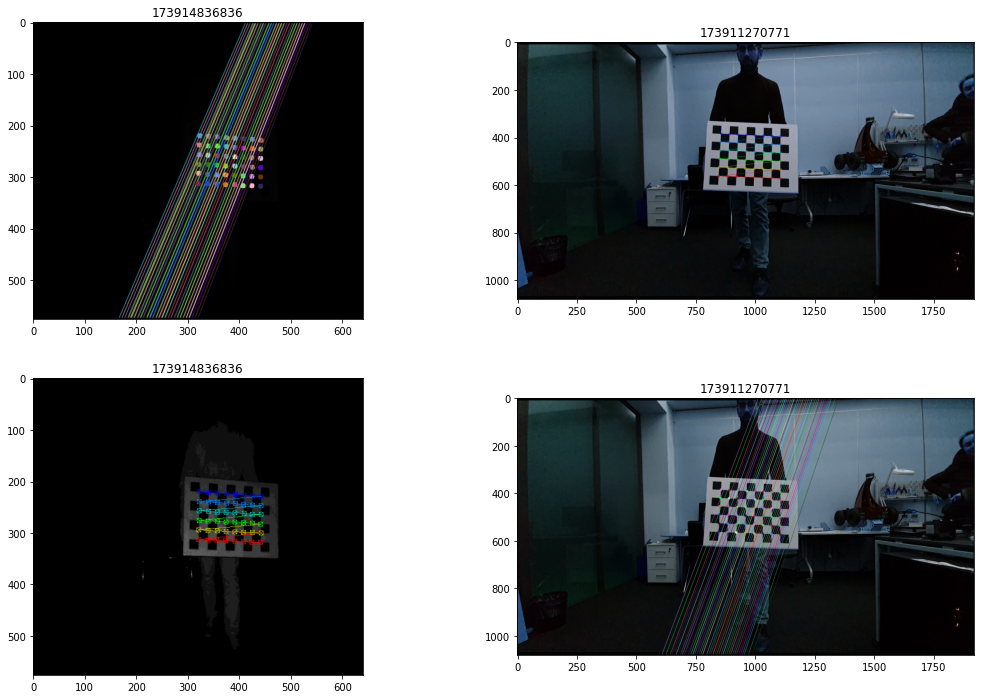

In [45]:
# 3) by plotting epipolar lines 

check_F = compose_fund_mat(check_T, azure_undist_intrinsics, s10_undist_intrinsics)

plot_epipolar_lines(azure_images[check_azure_key + img_ext], s10_images[check_s10_key + img_ext], 
                    azure_detections[check_azure_key + img_ext][1], s10_detections[check_s10_key + img_ext][1],
                    check_azure_key, check_s10_key, check_F, pattern_size)

In [49]:
# The initial solution as can be seen from epipolar lines is highly inaccurate thus we need to further 
# minimize avg. epipolar distance

kp1 = []
kp2 = []

K1 = []
K2 = []

local_kp1 = []

t_norm = []

for i, (s10_t, azure_t) in enumerate(zip(d_s10_timestamps, d_azure_timestamps)):    
    s10_kp, azure_kp = np.squeeze(s10_detections[s10_t + img_ext][1]), np.squeeze(azure_detections[azure_t + img_ext][1])
    local_kp1i = azure_chess[azure_t]
    
    print("Index:", i)
    
    # Do separate optimization for the initial guess to find pairs where the convergence is possible with relatively low error
    
    print("F optimization")
    
    T_opti = optimize_pose_lm(T_init, azure_kp, s10_kp, azure_undist_intrinsics, s10_undist_intrinsics)    
    
    if T_opti is not None:
        # Do translation scale optimization to make sure the solution in geometrically feasible
        
        print("t optimization")
        
        _, t_normi = optimize_translation_lm(T_opti, local_kp1i, s10_kp, s10_undist_intrinsics)
        
        t_norm.append(t_normi)
    
    kp1.append(azure_kp)
    kp2.append(s10_kp)
    
    K1.append(azure_undist_intrinsics)
    K2.append(s10_undist_intrinsics)
    
    local_kp1.append(local_kp1i)
    
    print()
    

kp1 = np.array(kp1)
kp2 = np.array(kp2)

K1 = np.array(K1)
K2 = np.array(K2)

local_kp1 = np.array(local_kp1)

t_norm = np.array(t_norm)
best_t_norm_idx = np.argsort(t_norm)


Index: 0
F optimization
Avg. epipolar distance: 0.1468580742812288
Number of iters: 163
t optimization
Avg. l2-norm: 0.43719939059818574
Number of iters: 37
Translation scale: 1.1835354509637064

Index: 1
F optimization
Avg. epipolar distance: 0.18935491816506791
Number of iters: 139
t optimization
Avg. l2-norm: 0.5845746095277926
Number of iters: 27
Translation scale: 1.1885128063011847

Index: 2
F optimization
Avg. epipolar distance: 0.9336119990540895
Number of iters: 108
t optimization
Avg. l2-norm: 3.9371253203177266
Number of iters: 19
Translation scale: -0.20397450827086197

Index: 3
F optimization
Avg. epipolar distance: 0.19850630320020102
Number of iters: 79
t optimization
Avg. l2-norm: 0.7448720470875173
Number of iters: 21
Translation scale: 1.1692381745737435

Index: 4
F optimization
Avg. epipolar distance: 1.0510199802296571
Number of iters: 58
t optimization
Avg. l2-norm: 19.595196209277592
Number of iters: 9
Translation scale: 1.2940667555052072

Index: 5
F optimization

In [128]:
print(best_t_norm_idx)
print(t_norm[best_t_norm_idx])

[44  0 45 40  7  6 34 18 41 32 29 36 38  1 35  9 17 42  3 16 33 10 19 31
 21 22 37  2 15 11 43  8 24 23 26 30 27 14 39 25 20  5  4 12 13 28]
[  0.37377902   0.43719939   0.4428057    0.45257721   0.48923818
   0.49295389   0.50197395   0.50223497   0.53939465   0.55327427
   0.56012615   0.57366913   0.58136158   0.58457461   0.66945237
   0.70297307   0.72580096   0.74212458   0.74487205   0.86375421
   0.93839677   1.41133144   1.69069265   1.78547396   2.1279582
   2.74002536   3.13563067   3.93712532   4.31094204   5.59340339
   7.3937242    8.43512435   9.13036838   9.16420606  10.26735374
  11.35373341  12.83886773  13.2996089   14.92878067  16.3450425
  18.01065984  18.29756881  19.59519621  21.51042684  27.06783754
 523.38777346]


In [187]:
# Select pairs with the lowest re-projection error. In general, should be less than 1 px
# It may also be that only one pair gives the best results

select_idx = [0]
selected_idx = best_t_norm_idx[select_idx]

print("Selected best idx:", selected_idx)
print("Selected avg. norm:", t_norm[selected_idx])

Selected best idx: [44]
Selected avg. norm: [0.37377902]


In [188]:
# Jointly optimize best pairs for both F and translation scale

print("F optimization")

T_opt = optimize_pose_lm(T_init, kp1[selected_idx], kp2[selected_idx],
                         K1[selected_idx], K2[selected_idx], True)

print(T_opt, end='\n\n')

print("t optimization")

T_opt, _ = optimize_translation_lm(T_opt, local_kp1[selected_idx], kp2[selected_idx], K2[selected_idx], True)

print(T_opt)

F optimization
Avg. epipolar distance: 0.1480941692416516
Number of iters: 19
[[ 0.99633845 -0.01217916  0.08462487 -0.19791399]
 [ 0.00338285  0.99464241  0.10332005  0.03511273]
 [-0.08542984 -0.10265546  0.99104167  0.05206075]
 [ 0.          0.          0.          1.        ]]

t optimization
Avg. l2-norm: 0.3737790167150499
Number of iters: 49
Translation scale: 1.1927501322431306
[[ 0.99633845 -0.01217916  0.08462487 -0.23606194]
 [ 0.00338285  0.99464241  0.10332005  0.04188072]
 [-0.08542984 -0.10265546  0.99104167  0.06209547]
 [ 0.          0.          0.          1.        ]]


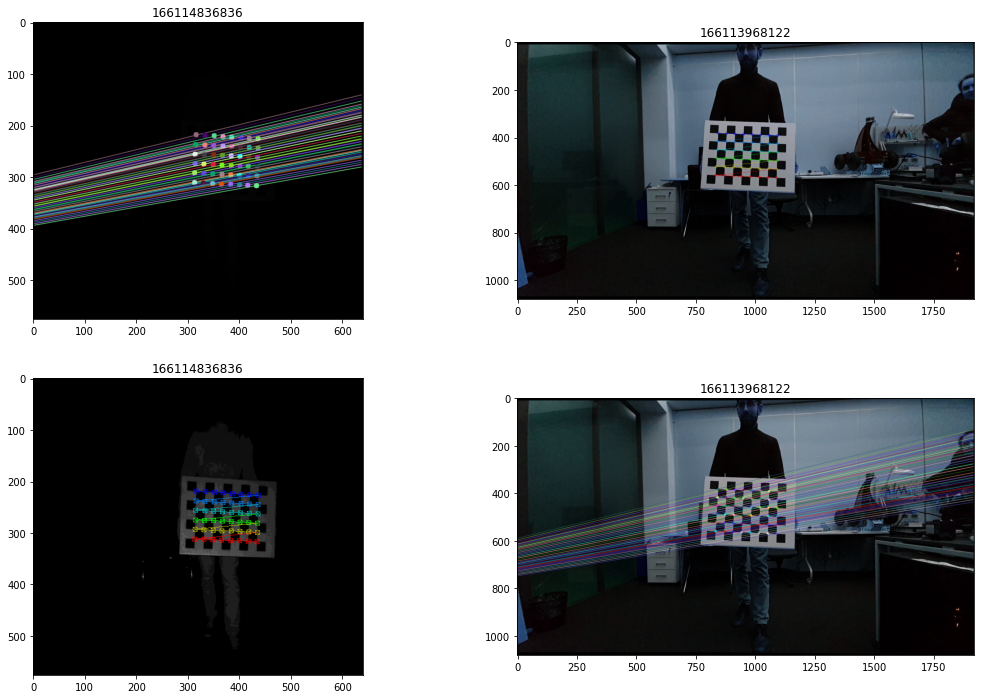

In [189]:
# Examine the solution after the optimization. Lines should be close to their corresponding points 
idx = 0

check_azure_key, check_s10_key = d_azure_timestamps[idx], d_s10_timestamps[idx]

check_F = compose_fund_mat(T_opt, azure_undist_intrinsics, s10_undist_intrinsics)

plot_epipolar_lines(azure_images[check_azure_key + '.png'], s10_images[check_s10_key + '.png'],
                    azure_detections[check_azure_key + '.png'][1], s10_detections[check_s10_key + '.png'][1], 
                    check_azure_key, check_s10_key, check_F, pattern_size)


### Visualize transformed keypoints, depth and tune the solution

In [190]:
# Transform all depth measurements to a point cloud
azure_pcd_depths = pointcloudify_depths(azure_depths, azure_undist_intrinsics)

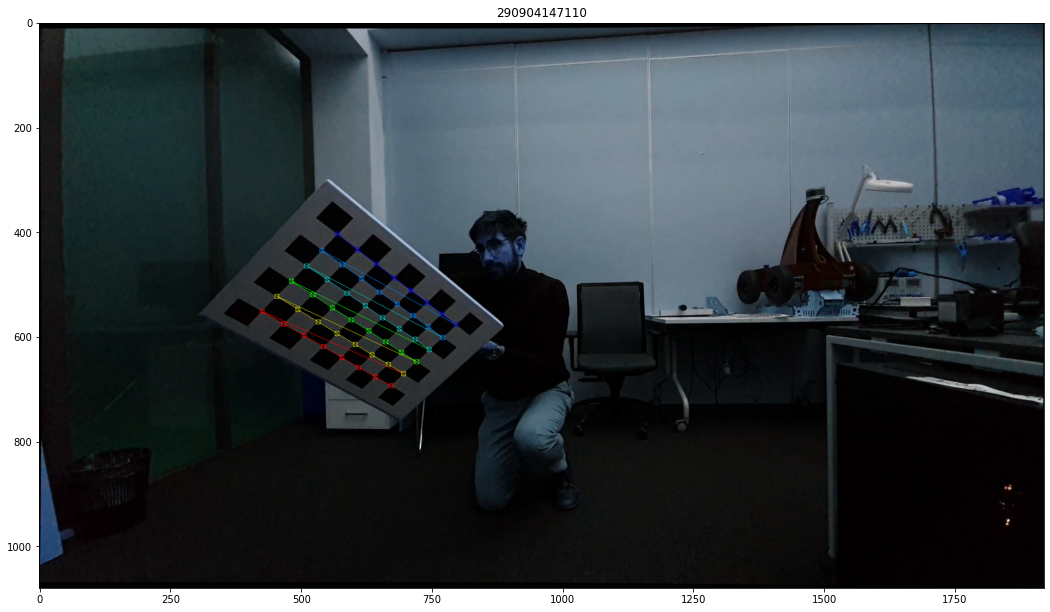

In [198]:
# Keypoints should be well aligned with their respective locations on multiple images

idx = 44

check_azure_key, check_s10_key = d_azure_timestamps[idx], d_s10_timestamps[idx]

check_azure_chess = to_cartesian((T_opt @ to_homogeneous(azure_chess[check_azure_key]).transpose()).transpose())

plot_projected_keypoints(s10_images[check_s10_key + img_ext], check_azure_chess, 
                         s10_undist_intrinsics, check_s10_key, pattern_size, fig_size=(18, 18), normalize=True)


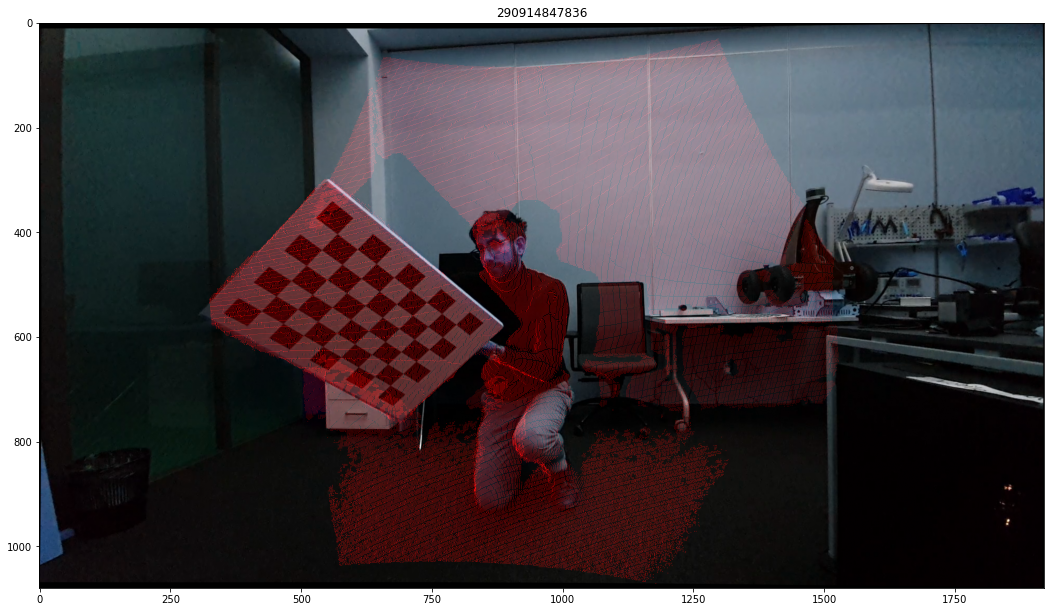

In [199]:
# Transform pointcloudified depth from azure to s10 system of coordinates and visualize it as a final check

check_azure_pcd = azure_pcd_depths[check_azure_key + depth_ext]
check_azure_pcd = to_cartesian((T_opt @ to_homogeneous(check_azure_pcd).transpose()).transpose())

plot_projected_pcd(s10_images[check_s10_key + img_ext], check_azure_pcd, s10_undist_intrinsics, check_azure_key)

In [200]:
np.save('calib_output/azure2s10_extrinsics', T_opt)